# [SDES](https://jhafranco.com/2012/02/10/simplified-des-implementation-in-python/) fourni par Joao H de A Franco

In [1]:
# Author: Joao H de A Franco (jhafranco@acm.org)
#
# Description: Simplified DES implementation in Python 3
#
# Date: 2012-02-10
#
# License: Attribution-NonCommercial-ShareAlike 3.0 Unported
#          (CC BY-NC-SA 3.0)
#===========================================================
from sys import exit
from time import time
 
KeyLength = 10
SubKeyLength = 8
DataLength = 8
FLength = 4

# Tables for initial and final permutations (b1, b2, b3, ... b8)
IPtable = (2, 6, 3, 1, 4, 8, 5, 7)
FPtable = (4, 1, 3, 5, 7, 2, 8, 6)
 
# Tables for subkey generation (k1, k2, k3, ... k10)
P10table = (3, 5, 2, 7, 4, 10, 1, 9, 8, 6)
P8table = (6, 3, 7, 4, 8, 5, 10, 9)
 
# Tables for the fk function
EPtable = (4, 1, 2, 3, 2, 3, 4, 1)
S0table = (1, 0, 3, 2, 3, 2, 1, 0, 0, 2, 1, 3, 3, 1, 3, 2)
S1table = (0, 1, 2, 3, 2, 0, 1, 3, 3, 0, 1, 0, 2, 1, 0, 3)
P4table = (2, 4, 3, 1)
 
def perm(inputByte, permTable):
    """Permute input byte according to permutation table"""
    outputByte = 0
    for index, elem in enumerate(permTable):
        if index >= elem:
            outputByte |= (inputByte & (128 >> (elem - 1))) >> (index - (elem - 1))
        else:
            outputByte |= (inputByte & (128 >> (elem - 1))) << ((elem - 1) - index)
    return outputByte
 
def ip(inputByte):
    """Perform the initial permutation on data"""
    return perm(inputByte, IPtable)
 
def fp(inputByte):
    """Perform the final permutation on data"""
    return perm(inputByte, FPtable)
 
def swapNibbles(inputByte):
    """Swap the two nibbles of data"""
    return (inputByte << 4 | inputByte >> 4) & 0xff
 
def keyGen(key):
    """Generate the two required subkeys"""
    def leftShift(keyBitList):
        """Perform a circular left shift on the first and second five bits"""
        shiftedKey = [None] * KeyLength
        shiftedKey[0:9] = keyBitList[1:10]
        shiftedKey[4] = keyBitList[0]
        shiftedKey[9] = keyBitList[5]
        return shiftedKey
 
    # Converts input key (integer) into a list of binary digits
    keyList = [(key & 1 << i) >> i for i in reversed(range(KeyLength))]
    permKeyList = [None] * KeyLength
    for index, elem in enumerate(P10table):
        permKeyList[index] = keyList[elem - 1]
    shiftedOnceKey = leftShift(permKeyList)
    shiftedTwiceKey = leftShift(leftShift(shiftedOnceKey))
    subKey1 = subKey2 = 0
    for index, elem in enumerate(P8table):
        subKey1 += (128 >> index) * shiftedOnceKey[elem - 1]
        subKey2 += (128 >> index) * shiftedTwiceKey[elem - 1]
    return (subKey1, subKey2)
 
def fk(subKey, inputData):
    """Apply Feistel function on data with given subkey"""
    def F(sKey, rightNibble):
        aux = sKey ^ perm(swapNibbles(rightNibble), EPtable)
        index1 = ((aux & 0x80) >> 4) + ((aux & 0x40) >> 5) + \
                 ((aux & 0x20) >> 5) + ((aux & 0x10) >> 2)
        index2 = ((aux & 0x08) >> 0) + ((aux & 0x04) >> 1) + \
                 ((aux & 0x02) >> 1) + ((aux & 0x01) << 2)
        sboxOutputs = swapNibbles((S0table[index1] << 2) + S1table[index2])
        return perm(sboxOutputs, P4table)
 
    leftNibble, rightNibble = inputData & 0xf0, inputData & 0x0f
    return (leftNibble ^ F(subKey, rightNibble)) | rightNibble
 
def encrypt(key, plaintext):
    """Encrypt plaintext with given key"""
    data = fk(keyGen(key)[0], ip(plaintext))
    return fp(fk(keyGen(key)[1], swapNibbles(data)))
 
def decrypt(key, ciphertext):
    """Decrypt ciphertext with given key"""
    data = fk(keyGen(key)[1], ip(ciphertext))
    return fp(fk(keyGen(key)[0], swapNibbles(data)))

# Extension SDES pour un texte de plus de 8 bits

In [2]:
def text_to_8bits_list(text):
    return [f'{ord(character):08b}' for character in text]

def encrypt_text(text, key):
    return ''.join([chr(encrypt(key, int(char, 2))) for char in text_to_8bits_list(text)])

def decrypt_text(text, key):
    return ''.join(chr(decrypt(key, int(char, 2))) for char in text_to_8bits_list(text))

# Extension double SDES

In [3]:
def double_encrypt_text(text, key1, key2):
    return encrypt_text(encrypt_text(text, key1), key2)

def double_decrypt_text(text, key1, key2):
    return decrypt_text(decrypt_text(text, key2), key1)

# Cassage brutal

In [4]:
def cassage_brutal(message_clair, message_chiffre, return_nb_tentatives = False):
    nb_tentatives = 0
    for key1 in range(0, 1024):
        for key2 in range(0, 1024):
            nb_tentatives += 1
            if double_decrypt_text(message_chiffre, key1, key2) == message_clair:
                return (key1, key2, nb_tentatives) if return_nb_tentatives else (key1, key2)

# Cassage astucieux

In [5]:
def cassage_astucieux(message_clair, message_chiffre, return_nb_tentatives = False):
    nb_tentatives = 0
    dict_key = {}
    set_encrypted_texts = set()
    for key in range(0, 1024):
        nb_tentatives += 1
        encrypted = encrypt_text(message_clair, key)
        dict_key[encrypted] = key
        set_encrypted_texts.add(encrypted)
    for key in range(0, 1024):
        nb_tentatives += 1
        decrypted_text = decrypt_text(message_chiffre, key)
        if decrypted_text in set_encrypted_texts:
            return (dict_key[decrypted_text], key, nb_tentatives) if return_nb_tentatives else (dict_key[decrypted_text], key)

# Évaluation de performances (nombre de clés testées et temps d'exécution)

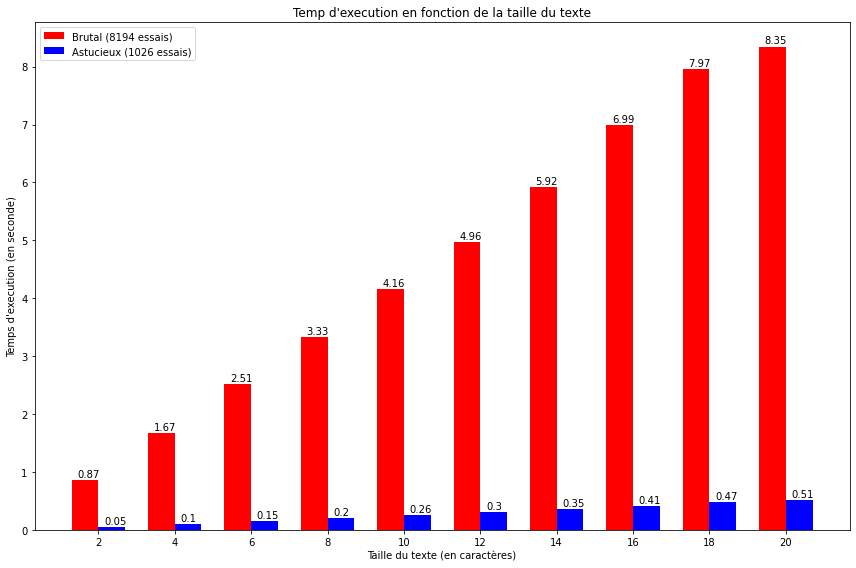

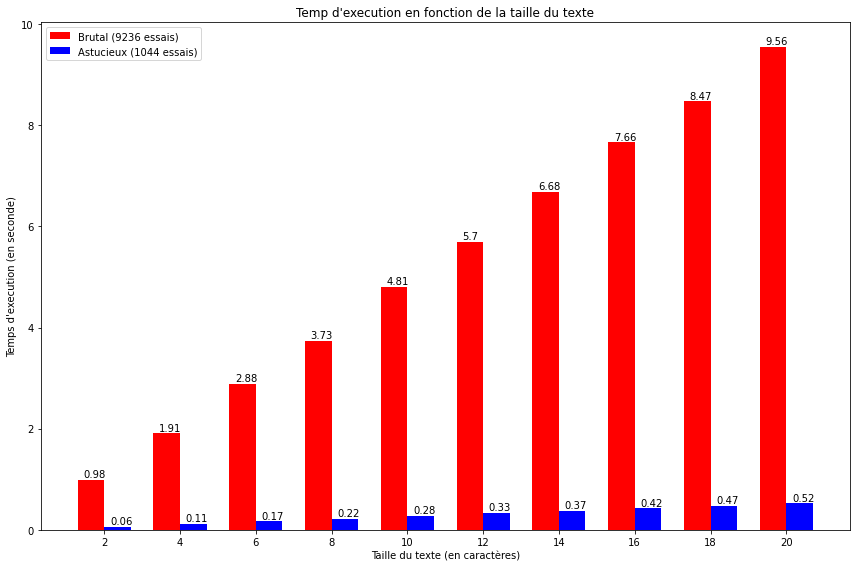

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random

def temps_execution(fonction, *args):
    start = time()
    result = fonction(*args)
    return (time() - start, result)

def graphique_temps_execution_cassages(textes):
    x_brutal = []
    y_brutal = []
    x_astucieux = []
    y_astucieux = []
    attempts_brutal = []
    attempts_astucieux = []
    key1 = random.randint(0, 20)
    key2 = random.randint(0, 20)
    for texte in textes:
        x_brutal.append(len(texte))
        result = temps_execution(cassage_brutal, texte, double_encrypt_text(texte, key1, key2), True)
        y_brutal.append(result[0])
        attempts_brutal = result[1][-1]
    for texte in textes:
        x_astucieux.append(len(texte))
        result = temps_execution(cassage_astucieux, texte, double_encrypt_text(texte, key1, key2), True)
        y_astucieux.append(result[0])
        attempts_astucieux = result[1][-1]
    bar_width = 0.35
    index = np.arange(len(x_brutal))
    plt.figure(figsize=(12, 8))
    plt.bar(index, y_brutal, bar_width, color='red', label=f'Brutal ({attempts_brutal} essais)')
    plt.bar(index + bar_width, y_astucieux, bar_width, color='blue', label=f'Astucieux ({attempts_astucieux} essais)')
    plt.xlabel('Taille du texte (en caractères)')
    plt.ylabel('Temps d\'execution (en seconde)')
    plt.title('Temp d\'execution en fonction de la taille du texte')
    for i, v in enumerate(y_brutal):
        plt.text(i - 0.1, v + 0.05, str(round(v, 2)))
    for i, v in enumerate(y_astucieux):
        plt.text(i + 0.25, v + 0.05, str(round(v, 2)))
    plt.xticks(index + bar_width / 2, x_brutal)
    plt.legend()
    plt.tight_layout()
    plt.show()
   
lettres_persanes = open("data/lettres_persanes.txt", "r").read()
arsene_lupin_extrait = open("data/arsene_lupin_extrait.txt", "r").read()

graphique_temps_execution_cassages([lettres_persanes[:2], arsene_lupin_extrait[:4], lettres_persanes[:6],
                                    arsene_lupin_extrait[:8], lettres_persanes[:10], arsene_lupin_extrait[:12],
                                    lettres_persanes[:14], arsene_lupin_extrait[:16], lettres_persanes[:18],
                                    arsene_lupin_extrait[:20]])
graphique_temps_execution_cassages([arsene_lupin_extrait[:2], lettres_persanes[:4], arsene_lupin_extrait[:6],
                                    lettres_persanes[:8], arsene_lupin_extrait[:10], lettres_persanes[:12],
                                    arsene_lupin_extrait[:14], lettres_persanes[:16], arsene_lupin_extrait[:18],
                                    lettres_persanes[:20]])